In [1]:
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pylab as plt
import matplotlib

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
reshape_dims = [IMG_HEIGHT,IMG_WIDTH]

CLASS_NAMES = ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

In [2]:
def read_and_decode(filename, reshape_dims):
  # 1.Read the file
  img = tf.io.read_file(filename)

  # 2.Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # 3.Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # 4.Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  #to find the only True label
  return img, label

#plot Training metrics
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [7]:
#define a function of initializing model
def train_and_evaluate(
        batch_size = 32,
        learning_rate = 0.0001,
        l1 = 0, l2 = 0,
        num_hidden = [64,16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset('/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv')
                   .map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")
                  .map(decode_csv)).batch(batch_size)

  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='Input_Layer')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer,
                            activation=tf.keras.activations.relu,
                            name='Hidden_Dense_Layer_{}'.format(hno))
      for hno, nodes in enumerate(num_hidden, start=1)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES),
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='Output_Layer')
  ]
  model = tf.keras.Sequential(layers, name='Flower_Classification')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "Flower_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Flatten)        (None, 150528)            0         
_________________________________________________________________
Hidden_Dense_Layer_1 (Dense) (None, 64)                9633856   
_________________________________________________________________
Hidden_Dense_Layer_2 (Dense) (None, 16)                1040      
_________________________________________________________________
Output_Layer (Dense)         (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 9s 83ms/step - loss: 1.8606 - accuracy: 0.2875 - val_loss: 1.6816 - val_accuracy: 0.3306
Epoch 2/10
104/104 [==============================] - 8s 73ms/step - loss: 1.5697 - a

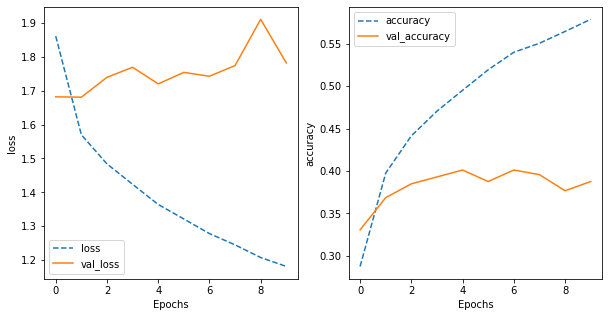

In [8]:
model = train_and_evaluate(learning_rate=0.0001, l2=0.001, num_hidden = [64, 16])

In [9]:
#define a function of initializing model, add dropout & batch norm
def train_and_evaluate(
        batch_size = 32,
        learning_rate = 0.0001,
        l1 = 0,
        l2 = 0.001,
        dropout = 0.4,
        num_hidden = [64,16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset('/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv')
                   .map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")
                  .map(decode_csv)).batch(batch_size)

  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='Input_Layer')]
  for hno, nodes in enumerate(num_hidden,start=1):
      layers.extend([
          tf.keras.layers.Dense(nodes,
                                kernel_regularizer=regularizer,
                                name='Hidden_Dense_Layer_{}'.format(hno)),
          tf.keras.layers.BatchNormalization(scale=False,  # ReLU
                                             center=False,  # have bias in Dense
                                             name='BatchNorm_Dense_Layer_{}'.format(hno)),
          # move activation to come after batchnorm
          tf.keras.layers.Activation('relu', name='ReLU_Dense_Layer_{}'.format(hno)),
          tf.keras.layers.Dropout(rate=dropout,
                                  name='Dropout_Dense_Layer_{}'.format(hno)),
      ])
  layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES),
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='Output_Layer')
  )
  model = tf.keras.Sequential(layers, name='Flower_Classification')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "Flower_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Flatten)        (None, 150528)            0         
_________________________________________________________________
Hidden_Dense_Layer_1 (Dense) (None, 64)                9633856   
_________________________________________________________________
BatchNorm_Dense_Layer_1 (Bat (None, 64)                128       
_________________________________________________________________
ReLU_Dense_Layer_1 (Activati (None, 64)                0         
_________________________________________________________________
Dropout_Dense_Layer_1 (Dropo (None, 64)                0         
_________________________________________________________________
Hidden_Dense_Layer_2 (Dense) (None, 16)                1040      
_________________________________________________________________
BatchNorm_Dense_Layer_2 (Bat (None, 16)      

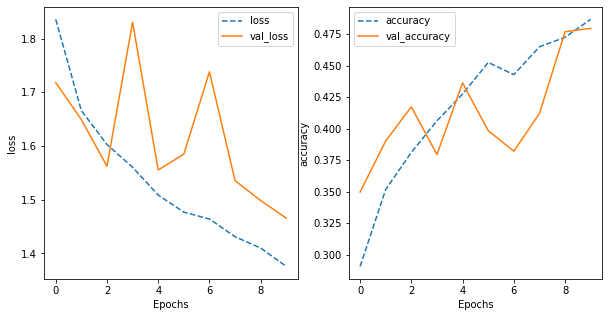

In [10]:
model = train_and_evaluate(learning_rate=0.0001, l2=0.001, dropout=0.4, num_hidden = [64, 16])